In [1]:
import torch
import torch_scatter
import pickle
import random
import datetime

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import lightning as L

from urllib.parse import unquote
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import Dataset, random_split
from dataclasses import dataclass
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, GraphNorm, LayerNorm
from torch_geometric.nn.models import GraphSAGE

/Users/faustogerman/miniforge3/envs/geometric/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the text data

In [2]:
# Load text data
data = pd.read_csv(f"../../data/full_text_data.csv")

### Load the links

In [3]:
# Load links
links = pd.read_csv("../../data/Wikispeedia/links.tsv", sep="\t", names=["src", "tgt"], skiprows=12)
links["src"] = links["src"].map(lambda x: unquote(x))
links["tgt"] = links["tgt"].map(lambda x: unquote(x))

# Create adjacency matrix
ordered_data_titles = data["title"].tolist()
src_indices = links["src"].map(lambda x: ordered_data_titles.index(x))
tgt_indices = links["tgt"].map(lambda x: ordered_data_titles.index(x))
A = torch.zeros((len(ordered_data_titles), len(ordered_data_titles)))
A[src_indices, tgt_indices] = 1

In [4]:
# Load coherence graph
with open("../../data/coherence_graph.pkl", 'rb') as handle:
    coherence_graph = pickle.load(handle)

# Combine coherence graph with base links
edge_features = A * coherence_graph

In [5]:
# Load node embeddings
with open("../../data/gpt4_embeddings.pkl", 'rb') as handle:
    obj = pickle.load(handle)
    node_static_embeddings = obj["embeddings"]
    del obj
node_static_embeddings = torch.tensor(node_static_embeddings, dtype=torch.float)
node_static_embeddings

/var/folders/ww/02m6b2_s1bl0sbzz4jq19n500000gn/T/ipykernel_47210/2880839170.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_static_embeddings = torch.tensor(node_static_embeddings, dtype=torch.float)


tensor([[ 0.0038,  0.0096,  0.0519,  ..., -0.0275,  0.0512, -0.0136],
        [-0.0361,  0.0142,  0.0874,  ..., -0.0140, -0.0216,  0.0194],
        [ 0.0341,  0.0069,  0.0078,  ...,  0.0070,  0.0373, -0.0153],
        ...,
        [-0.0165,  0.0102,  0.0054,  ...,  0.0072,  0.0459, -0.0378],
        [-0.0212,  0.0331,  0.0266,  ..., -0.0187,  0.0237, -0.0141],
        [ 0.0375,  0.0523,  0.0282,  ...,  0.0183, -0.0107, -0.0030]])

### Load the User-Extracted Paths

In [6]:
# Load user-extracted paths
paths_data = pd.read_csv(f"../../data/paths_no_back_links.tsv", sep="\t")
paths_data = paths_data[~(paths_data["rating"].isna())]

# Make the reatings binary
paths_data["rating"] = paths_data["rating"].apply(lambda x: 1 if x >= 3 else 0)

# Map titles to indices
title_to_index = {unquote(title): idx for idx, title in enumerate(data['title'])}
paths = paths_data['path'].apply(lambda path: [title_to_index[unquote(title)] for title in path.split(';')]).tolist()
ratings = paths_data['rating'].tolist()  # 0-indexed ratings
durations = paths_data['durationInSec'].tolist()

In [9]:
len(data)

4604

In [8]:
len(paths), len(ratings), len(durations)

(28501, 28501, 28501)

<Axes: >

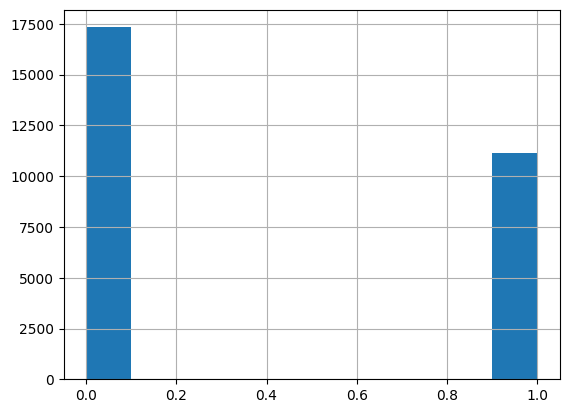

In [7]:
paths_data["rating"].hist()

In [8]:
class PathDataset(Dataset):
    def __init__(self, paths, ratings, durations, node_embeddings, edge_features):
        self.paths = paths
        self.ratings = ratings
        self.durations = durations
        self.node_embeddings = node_embeddings
        self.edge_features = edge_features

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        rating = int(self.ratings[idx])
        duration = self.durations[idx]
        nodes, edge_index, edge_weight = self.get_subgraph_edges(path)

        x = self.node_embeddings[nodes]

        data = Data(
            x=x,
            durations=duration,
            edge_index=edge_index,
            edge_weight=edge_weight,
            y=rating
        )
        return data

    def get_subgraph_edges(self, path):
        nodes = list(set(path))
        node_to_idx = {node: idx for idx, node in enumerate(nodes)}
        edges = []
        edge_weights = []
        for i in nodes:
            for j in nodes:
                weight = self.edge_features[i, j]
                if weight > 0:
                    edges.append([node_to_idx[i], node_to_idx[j]])
                    edge_weights.append(weight)
        if edges:
            edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
            edge_weight = torch.tensor(edge_weights, dtype=torch.float)
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)
            edge_weight = torch.tensor([], dtype=torch.float)
        return nodes, edge_index, edge_weight

# Create dataset
dataset = PathDataset(paths, ratings, durations, node_static_embeddings, edge_features)

# Split dataset
train_ratio = 0.85
val_ratio = 0.05
test_ratio = 0.1
total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42)
)

# Create data loaders
batch_size = 6
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

#### Map the Path Titles to Node Indices

In [9]:
# Counts occurrences of each class
class_counts = torch.bincount(
    torch.tensor(ratings)[train_dataset.indices].to(torch.int64)
)

# Calculate weights as the inverse of class frequencies
class_weights = 1.0 / class_counts.float()

# Normalize the weights so that they sum to the number of classes
class_weights = class_weights / class_weights.sum() * len(class_counts)

class_weights

tensor([0.7851, 1.2149])

#### Class Weights for Imbalanced Training

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def conf_matrix(model, dataset_loader):
    # Pass the testing loader through the model
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for batch in dataset_loader:
            logits = model(batch.x, batch.edge_index, batch.durations, batch.batch)
            preds = logits.argmax(dim=1).cpu().numpy()
            labels = batch.y.cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels)

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)

    # Plot confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

## The Model

In [11]:
class Model(nn.Module):
    def __init__(self, node_in_feats, hidden_feats, num_classes, dropout=0.0, bias=True):
        super(Model, self).__init__()
        self.sage = GraphSAGE(
            in_channels=node_in_feats,
            hidden_channels=hidden_feats,
            num_layers=1,
            dropout=dropout,
            bias=bias
        )

        # GRU for sequence-based aggregation
        self.gru = nn.GRU(
            input_size=hidden_feats,
            hidden_size=hidden_feats,
            num_layers=3,
            batch_first=True,
        )

        self.classifier_head = nn.Sequential(
            nn.Linear(hidden_feats + 1, hidden_feats),
            nn.ReLU(),
            nn.Linear(hidden_feats, num_classes)
        )

    def forward(self, node_features, edge_index, durations, batch_mask):
        sage_out = self.sage(node_features, edge_index)

        # Use GRU to aggregate node embeddings based on node order
        # Group nodes by graph using the batch_mask
        unique_graphs = batch_mask.unique()
        graphs_embeddings = []
        
        for graph_id in unique_graphs:
            # Shape: [1, num_nodes_in_graph, hidden_channels]
            curr_graph_nodes = sage_out[batch_mask == graph_id].unsqueeze(0)
            
            # Pass through GRU. The GRU processes the nodes in the order
            # specified by node_order internally and outputs the last hidden state
            _, hidden_state = self.gru(curr_graph_nodes)  # hidden_state: [num_gru_layers, 1, gru_hidden_size]
            graphs_embeddings.append(hidden_state[-1, 0])  # Take the last layer's hidden state for this graph

        # Stack all graph embeddings
        graphs_embeddings = torch.stack(graphs_embeddings)  # Shape: [num_graphs, gru_hidden_size]
        graphs_embeddings = torch.cat([graphs_embeddings, durations.unsqueeze(1)], dim=1)
        
        return self.classifier_head(graphs_embeddings)

In [12]:
MODEL = Model(
    node_static_embeddings.shape[1],
    hidden_feats=512,  # Hidden layer size for GraphSAGE
    num_classes=2,  # Number of classes
)

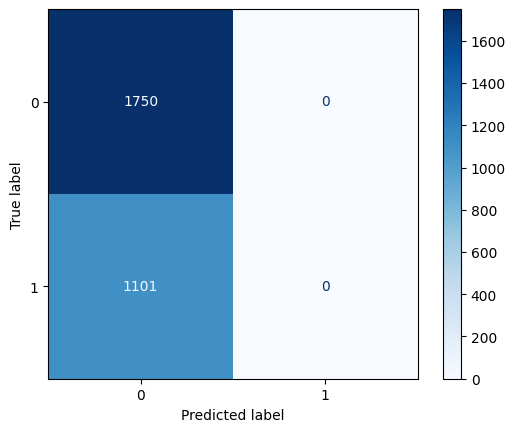

In [13]:
conf_matrix(MODEL, test_loader)

## Training the Model

In [14]:
class LitModel(L.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config

    def training_step(self, batch, batch_idx):
        logits = self.do_forward(batch)
        loss = self.compute_loss(logits, batch.y)

        loss = self.compute_loss(logits, batch.y)
        acc = self.compute_accuracy(logits, batch.y)

        # Log training loss and accuracy
        self.log("training_loss", loss, on_step=True, on_epoch=True, logger=True, batch_size=batch_size)
        self.log("training_accuracy", acc, on_step=True, on_epoch=True, logger=True, batch_size=batch_size)

        return loss

    def test_step(self, batch):
        logits = self.do_forward(batch)

        loss = self.compute_loss(logits, batch.y)
        acc = self.compute_accuracy(logits, batch.y)

        self.log("test_loss", loss, on_step=True, on_epoch=True, batch_size=batch_size)
        self.log("test_accuracy", acc, on_step=True, on_epoch=True, batch_size=batch_size)

    def validation_step(self, batch, batch_idx):
        logits = self.do_forward(batch)

        loss = self.compute_loss(logits, batch.y)
        acc = self.compute_accuracy(logits, batch.y)

        # Log validation loss and accuracy
        self.log("validation_loss", loss, on_step=True, on_epoch=True, logger=True, batch_size=batch_size)
        self.log("validation_accuracy", acc, on_step=True, on_epoch=True, logger=True, batch_size=batch_size)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            params=self.model.parameters(),
            lr=self.config.learning_rate,
            weight_decay=self.config.weight_decay,
            betas=(self.config.beta1, self.config.beta2),
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": ReduceLROnPlateau(optimizer),
                "interval": "epoch",
                "frequency": 1,
                "monitor": "validation_loss",
                "strict": True,
            }
        }

    def do_forward(self, batch):
        """This is a custom method not associated with Lightning"""
        return self.model(
            node_features=batch.x,
            edge_index=batch.edge_index,
            durations=batch.durations,
            batch_mask=batch.batch
        )

    def compute_loss(self, logits, targets):
        """This is a custom method not associated with Lightning"""
        targets = targets.type(torch.long)
        return F.cross_entropy(logits, targets, weight=class_weights)

    def compute_accuracy(self, logits, targets):
        """This is a custom method not associated with Lightning"""
        return (logits.argmax(1) == targets).float().mean()

In [15]:
@dataclass
class ModelConfig:
    learning_rate: float = 1e-3
    weight_decay: float = 5e-4
    beta1: float = 0.9
    beta2: float = 0.999
    grad_clip: float = None
    num_epochs: int = 6
    log_interval: int = 1
    grad_accumulation: int = 1
    wandb_project: str = "wikispeedia_v3"


config = ModelConfig()

In [16]:
# model
the_model = LitModel(MODEL, config)

In [17]:
# Create the Lightning Model
lit_model = LitModel(MODEL, config)

# Test the model with one batch
# to make sure everything is working
it = next(iter(test_loader))
lit_model.test_step(it)

/Users/faustogerman/miniforge3/envs/geometric/lib/python3.9/site-packages/lightning/pytorch/core/module.py:445: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


In [18]:
# logging
wandb_logger = WandbLogger(
    project=config.wandb_project,
    name=datetime.datetime.now().strftime("%b-%d-%y @ %I:%M %p"),
    log_model="all",
    config=config
)

wandb_logger.watch(MODEL, log="all")

# Define the trainer
trainer = L.Trainer(
    default_root_dir="some/path/",
    max_epochs=config.num_epochs,
    val_check_interval=0.5,
    log_every_n_steps=config.log_interval,
    accumulate_grad_batches=config.grad_accumulation,
    gradient_clip_val=config.grad_clip,
    profiler="simple",
    logger=wandb_logger,
    # NOTE: Should be commented out if using GPU. There may be bugs related
    # to tensor device placements, since I have not tested this on GPU.
    accelerator="cpu",
)

# train model
trainer.fit(
    model=the_model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: faustotnc. Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/faustogerman/miniforge3/envs/geometric/lib/python3.9/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name  | Type  | Params | Mode
---------------------------------------
0 | model | Model | 6.6 M  | eval
---------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.262    Total estimated model params size (MB)
0         Modules in train mode
17        Modules in eval mode


/Users/faustogerman/miniforge3/envs/geometric/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/faustogerman/miniforge3/envs/geometric/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 5: 100%|██████████| 4038/4038 [08:55<00:00,  7.54it/s, v_num=y0js]

`Trainer.fit` stopped: `max_epochs=6` reached.


Epoch 5: 100%|██████████| 4038/4038 [08:55<00:00,  7.54it/s, v_num=y0js]

FIT Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                         	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                          	|  -              	|  912621         	|

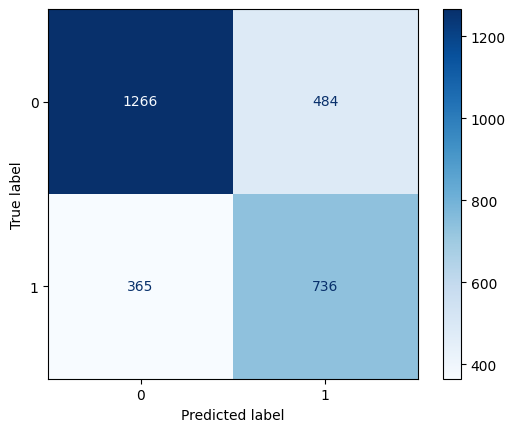

In [19]:
conf_matrix(MODEL, test_loader)